# Предсказание времени исправления багов в gcc

Задача состоит в предсказании времени, необходимого на исправление багов, на основе описания бага.

Набор данных содержит многолетние логи.

### Импорт нужных модулей

In [441]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
%matplotlib inline

### Читаем данные

In [442]:
data_url = 'https://raw.githubusercontent.com/Sandro295/Masters-ML/main/gcc_bug_report_data.csv'
data_raw = pd.read_csv(data_url)

data_raw.shape

(10000, 19)

Датасет состоит из _10 000_ записей и _19_ признаков

Посмотрим на загруженные данные

In [443]:
data_raw.head(5)

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,GCC-49282,2011-06-04,middle-end,GCC,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,fixed,1,resolved,4,2011-10-07,0,9,2011-10-07,125,normal,2
1,GCC-36574,2008-06-19,middle-end,GCC,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,fixed,1,resolved,4,2008-07-18,0,5,2008-07-18,29,normal,2
2,GCC-77269,2016-08-16,middle-end,GCC,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,fixed,1,resolved,4,2016-08-22,0,5,2016-08-22,6,normal,2
3,GCC-78479,2016-11-22,fortran,GCC,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,fixed,1,resolved,4,2016-11-22,0,6,2016-11-22,0,normal,2
4,GCC-632,2000-10-12,c++,GCC,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,fixed,1,resolved,4,2003-07-25,0,5,2001-02-04,115,normal,2


Видно, что данные состоят из числовых, категориальных и текстовых признаков.

## Список признаков и их описания

In [444]:
data_raw.dtypes

bug_id                  object
creation_date           object
component_name          object
product_name            object
short_description       object
long_description        object
assignee_name           object
reporter_name           object
resolution_category     object
resolution_code          int64
status_category         object
status_code              int64
update_date             object
quantity_of_votes        int64
quantity_of_comments     int64
resolution_date         object
bug_fix_time             int64
severity_category       object
severity_code            int64
dtype: object

Заранее поменяем тип у категориальных признаков (с _object_ на _category_)

In [445]:
for column in data_raw.select_dtypes(['object']):
    data_raw[column] = data_raw[column].astype('category')

In [446]:
data_raw.dtypes

bug_id                  category
creation_date           category
component_name          category
product_name            category
short_description       category
long_description        category
assignee_name           category
reporter_name           category
resolution_category     category
resolution_code            int64
status_category         category
status_code                int64
update_date             category
quantity_of_votes          int64
quantity_of_comments       int64
resolution_date         category
bug_fix_time               int64
severity_category       category
severity_code              int64
dtype: object

### Входные признаки

####  Числовые признаки

* __bug_id__ - уникальный идентификатор бага
* __creation_date__ - дата создания тикета
* __resolution_category__ - статус задачи
* __status_code__ - код задачи
* __update_date__ - дата последнего обновления тикета
* __quantity_of_votes__ - количество голосов в тикете
* __quantity_of_comments__ - количество комментариев
* __resolution_date__ - дата закрытия тикета
* __bug_fix_time__ - время исправления бага в днях
* __severity_category__ - уровень критичности бага
* __severity_code__ - код уровня критичности бага

####  Категориальные признаки

* __component_name__ - компонент продукта с ошибкой
* __product_name__ - продукт с ошибкой
* __assignee_name__ - никнейм взявшего тикет
* __reporter_name__ - никнейм ответственного за проверку

####  Текстовые признаки
* __short_description__ - краткое описание появившейся проблемы
* __long_description__ - подробное описание проблемы


### Выходной признак

* __bug_fix_time__ - время разрешения тикета

## Чистка данных

In [447]:
data_raw.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,10000.0,10000.000000,10000.0,10000.000000,10000.0000,10000.00000
mean,1.0,4.019400,0.0,8.145000,225.8268,2.22120
std,0.0,0.196029,0.0,6.553859,516.6366,0.79758
min,1.0,4.000000,0.0,1.000000,-527.0000,1.00000
25%,1.0,4.000000,0.0,4.000000,3.0000,2.00000
50%,1.0,4.000000,0.0,6.000000,27.0000,2.00000
75%,1.0,4.000000,0.0,10.000000,188.0000,2.00000
max,1.0,6.000000,0.0,124.000000,5351.0000,6.00000


Первым делом очистим данные. __bug_id__ уникален для каждого, поэтому его можно заменить порядковым номером строки, 
__xx_category__ и __xx_code__ несут одинаковую информацию.
__product_name__ в этом датасете один. __resolution_category__ везде 1.
__update_date__ и __resolution_date__ как правило одинаковы.
__quantity_of_votes__ везде 0.


In [448]:
data_raw.isna().sum()

bug_id                   0
creation_date            0
component_name           0
product_name             0
short_description        6
long_description        14
assignee_name            0
reporter_name            0
resolution_category      0
resolution_code          0
status_category          0
status_code              0
update_date              0
quantity_of_votes        0
quantity_of_comments     0
resolution_date          0
bug_fix_time             0
severity_category        0
severity_code            0
dtype: int64

Также избавимся от строк с пропущенными данными.

In [449]:
data = data_raw.drop(['bug_id','severity_category', 'product_name', 'update_date', 'resolution_category', 'resolution_code', 'status_category', 'quantity_of_votes'], axis=1).dropna()

In [450]:
data_raw.describe(include=['category'])

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,status_category,update_date,resolution_date,severity_category
count,10000,10000,10000,10000,9994,9986,10000,10000,10000,10000,10000,10000,10000
unique,10000,4846,55,2,9928,9958,270,3287,1,2,3642,4490,6
top,CLASSPATH-16040,2000-12-20,c++,GCC,Internal compiler error,,unassigned,hjl.tools,fixed,resolved,2003-07-25,2005-07-23,normal
freq,1,77,2217,9731,9,19,5149,292,10000,9903,1553,58,8895


In [451]:
data.describe(include=['category'])

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,resolution_date
count,9980,9980,9980,9980,9980,9980,9980
unique,4840,55,9914,9953,270,3275,4487
top,2000-12-20,c++,Internal compiler error,,unassigned,hjl.tools,2005-07-23
freq,77,2213,9,19,5136,292,58


In [452]:
data.head(5)

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code
0,2011-06-04,middle-end,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,4,9,2011-10-07,125,2
1,2008-06-19,middle-end,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,4,5,2008-07-18,29,2
2,2016-08-16,middle-end,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,4,5,2016-08-22,6,2
3,2016-11-22,fortran,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,4,6,2016-11-22,0,2
4,2000-10-12,c++,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,4,5,2001-02-04,115,2


## Визуализация и предварительный анализ данных

### Описательная статистика матрицы данных

#### Информация о числовых признаках

In [453]:
data.describe()

,status_code,quantity_of_comments,bug_fix_time,severity_code
count,9980.000000,9980.000000,9980.000000,9980.000000
mean,4.019038,8.147094,225.961222,2.221443
std,0.194210,6.557003,516.901518,0.798122
min,4.000000,1.000000,-527.000000,1.000000
25%,4.000000,4.000000,3.000000,2.000000
50%,4.000000,6.000000,27.000000,2.000000
75%,4.000000,10.000000,188.000000,2.000000
max,6.000000,124.000000,5351.000000,6.000000


По таблице можно увидеть, что какие-то баги решались за отрицательное время, что можно трактовать как позднее создание тикета или выброс в данных, от которого надо избавиться.

In [454]:
data.drop(data[data.bug_fix_time < 0].index, inplace=True)
data.describe()

,status_code,quantity_of_comments,bug_fix_time,severity_code
count,9928.000000,9928.000000,9928.000000,9928.000000
mean,4.019138,8.154613,228.494158,2.221998
std,0.194713,6.569078,516.972198,0.799083
min,4.000000,1.000000,0.000000,1.000000
25%,4.000000,4.000000,3.000000,2.000000
50%,4.000000,6.000000,28.000000,2.000000
75%,4.000000,10.000000,190.000000,2.000000
max,6.000000,124.000000,5351.000000,6.000000


### Визуализация данных

В процессе визуализации могут проявиться некоторые особенности данных, с которыми необходимо будет разобраться

Посмотрим на сбалансированность/несбалансированность классов

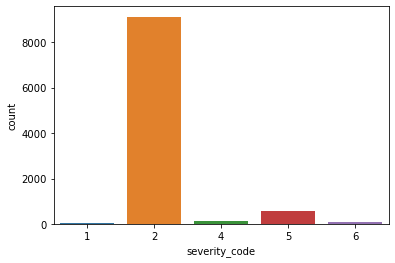

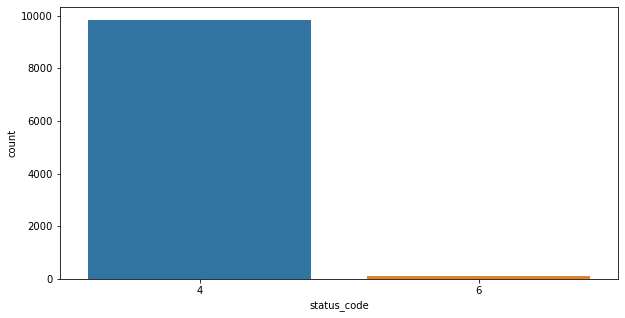

In [455]:
sns.countplot(x='severity_code', data=data)
plt.figure(figsize=(10, 5))
sns.countplot(x='status_code', data=data)
pass

Видно, что классы ___несбалансированны___. Впоследствии имеет смысл попытаться избавиться от несбалансированности.

У большинства багов одинаковая важность.

Построим графики зависимостей каждого количественного признака с каждым

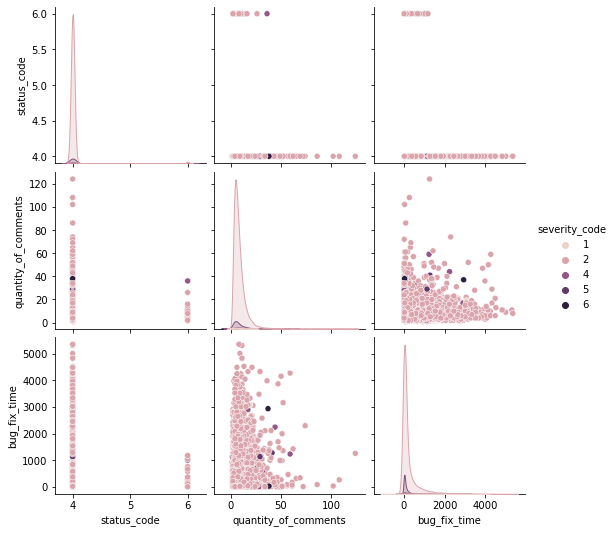

In [456]:
sns.pairplot(data, hue='severity_code')

Посмотрим на время решения проблемы относительно времени создания тикета. <br>_iloc[::dec]_ - добавим для децимации данных, чтобы не строить график от 10000 вхождений, потому что общие тренды можно увидеть и с меньшим количеством данных.

In [457]:
data['bug_fix_time'].quantile(q=[0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005       0.000
0.010       0.000
0.050       0.000
0.100       1.000
0.500      28.000
0.900     668.300
0.950    1178.950
0.990    2703.190
0.995    3341.285
Name: bug_fix_time, dtype: float64

In [458]:
rows_to_drop = data[
    (data_raw['bug_fix_time'] < data_raw['bug_fix_time'].quantile(0.5)) | (data_raw['bug_fix_time'] > data_raw['bug_fix_time'].quantile(0.995))
    ].index
data.drop(rows_to_drop, inplace=True)


C:\Users\danil\AppData\Local\Temp\ipykernel_6300\1759764291.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rows_to_drop = data[


In [496]:
bug_fix_time_col = pd.cut(data['bug_fix_time'], bins=50)

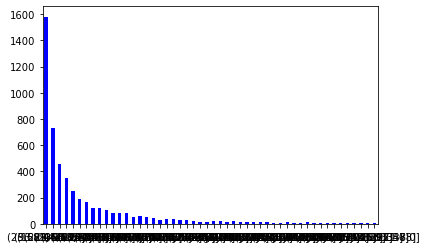

In [497]:
dec = 3
ax = bug_fix_time_col.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
plt.show()

# fixing_time_plot = sns.lineplot(x = data['creation_date'], y = bug_fix_time_col);

In [498]:
data['bug_fix_time_binned'] = bug_fix_time_col

In [499]:
data['bug_fix_time_binned'] = data['bug_fix_time_binned'].apply(lambda x: int(x.left))

Видно, что GCC уже в зрелом состоянии и новые баги исправляются всё быстрее и быстрее.

Построим матрицу корреляции для количественных признаков и визуализируем её

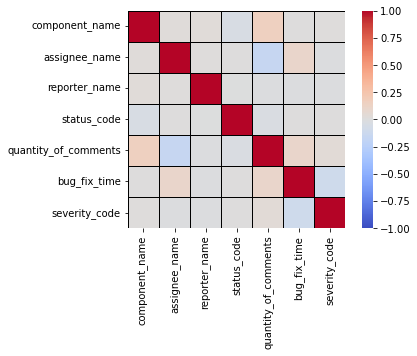

In [500]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=1, linecolor="black")
pass

Напрашивается очевидный вывод: чем выше уровень критичности, тем дольше ведется дискуссия и дольше вносятся исправления.

## Обработка категориальных признаков

In [501]:
data.head()

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code,bug_fix_time_binned
0,2011-06-04,34.0,malloc corrupt larg lto1wpa run dure inlin edg...,larg lto1wpa run 20110603 result mallocc3551 m...,203.0,138.0,4,9,2011-10-07,125,2,93
1,2008-06-19,34.0,44 regression build broken cgraph chang,r136888 criself built 4 regress compar earlier...,203.0,841.0,4,5,2008-07-18,29,2,23
4,2000-10-12,5.0,intern compil error layout_decl storlayoutc274,g ihomeleilasourcesinclud o2 wall woverloadedv...,203.0,1179.0,4,5,2001-02-04,115,2,93
5,2001-08-21,32.0,make instal instal includegv3makefil,couldnt work categoryclass problem like thi go...,27.0,1513.0,4,7,2001-10-10,50,2,23
6,2015-07-27,43.0,49 regression wrong code o1 abov arm,creat attach 36076 testcas reduc testcas base ...,21.0,1415.0,4,14,2016-08-03,373,2,358


Обработаем признаки _component_name_, _assignee_name_ и _reporter_name_. Поскольку они принимают уникальные текстовые значения, а смысл несет не столько предложение, сколько непосредственно само слово, удобным будет заменить их числовыми значениями.<br> Метод бинаризации (one-hot encoding) __не__ подойдет, потому что уникальных значений много (несколько сотен).<br>
Зато ordinal enconig сюда отлично впишется

In [502]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
data_encoded_cn = enc.fit_transform(np.asarray(data['component_name']).reshape(-1,1))
data_encoded_an = enc.fit_transform(np.asarray(data['assignee_name']).reshape(-1,1))
data_encoded_rn = enc.fit_transform(np.asarray(data['reporter_name']).reshape(-1,1))

In [503]:
data['component_name'] = data_encoded_cn
data['assignee_name'] = data_encoded_an
data['reporter_name'] = data_encoded_rn

In [504]:
data.head()

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code,bug_fix_time_binned
0,2011-06-04,34.0,malloc corrupt larg lto1wpa run dure inlin edg...,larg lto1wpa run 20110603 result mallocc3551 m...,203.0,138.0,4,9,2011-10-07,125,2,93
1,2008-06-19,34.0,44 regression build broken cgraph chang,r136888 criself built 4 regress compar earlier...,203.0,841.0,4,5,2008-07-18,29,2,23
4,2000-10-12,5.0,intern compil error layout_decl storlayoutc274,g ihomeleilasourcesinclud o2 wall woverloadedv...,203.0,1179.0,4,5,2001-02-04,115,2,93
5,2001-08-21,32.0,make instal instal includegv3makefil,couldnt work categoryclass problem like thi go...,27.0,1513.0,4,7,2001-10-10,50,2,23
6,2015-07-27,43.0,49 regression wrong code o1 abov arm,creat attach 36076 testcas reduc testcas base ...,21.0,1415.0,4,14,2016-08-03,373,2,358


## Обработка текстовых признаков

Признак _long_description_ содержит подробное описание проблемы, обычно с примерами _C_ кода, иногда даже с полученным _ASM_ кодом. Признак никак не нормирован и не подходит для анализа без предварительной обработки. <br>
Поскольку мне неизвестны продвинутые методы обработки осмысленных текстов, я воспользуюсь грубым, но простым и понятным методом _Bag of Words_ (BOW).

Признак _short_description_ содержит не более одного предложения, составленного из некоторых ключевых слов. Для него BOW подходит как нельзя лучше. 

Для использования метода BOW необходимо привести данные к единому виду. Для этого переведем все символы в строчные, а также применим stemming - грубое сокращение слов до их неизменяемой при склонении части. <br> 
А также удалим пунктуацию и стоп-слова. Здесь возникает небольшая проблема - в некоторых описаниях знаки пунктуации используются в программном смысле, т.е., например, scope resolvement operator «::» или member access operator «.». <br>
Оценка и так будет грубой, а с таким действием будет еще немного грубее. 

In [505]:
def lower(text):
    return text.lower()

In [506]:
from nltk.stem import PorterStemmer
  
def stemming(text):
    return ' '.join([PorterStemmer().stem(w) for w in text.split()])

In [507]:
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

def remove_space(text):
    return re.sub(r"\s+"," ",text).strip()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [508]:
def filter_text(text):
    text = lower(text)
    text = stemming(text)
    text = punct_remove(text)
    text = remove_stopwords(text)
    text = remove_space(text)
    return text

In [509]:
data['short_description'] = data['short_description'].apply(lambda x:filter_text(x))

In [510]:
data['long_description'] = data['long_description'].apply(lambda x:filter_text(x))

## Word cloud

Посмотрим на самые частые слова в описаниях

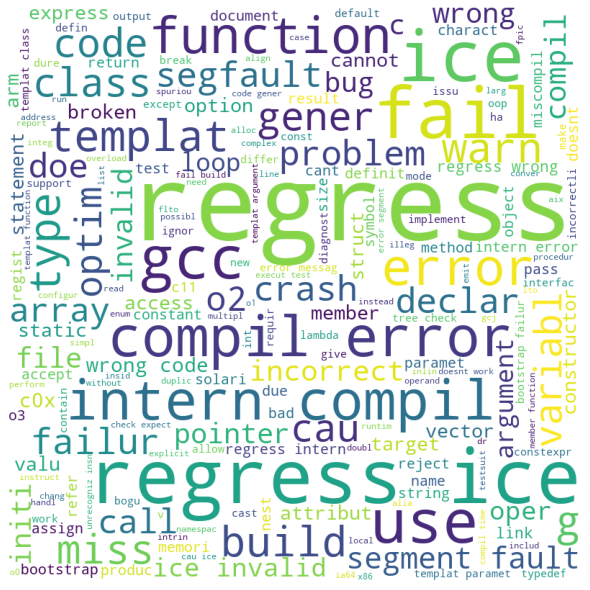

In [511]:
from wordcloud import WordCloud

text = " ".join(data['short_description'])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 

Можно подумать, что все беды из-за интернов, однако _intern_ - результат стемминга слова _internal_

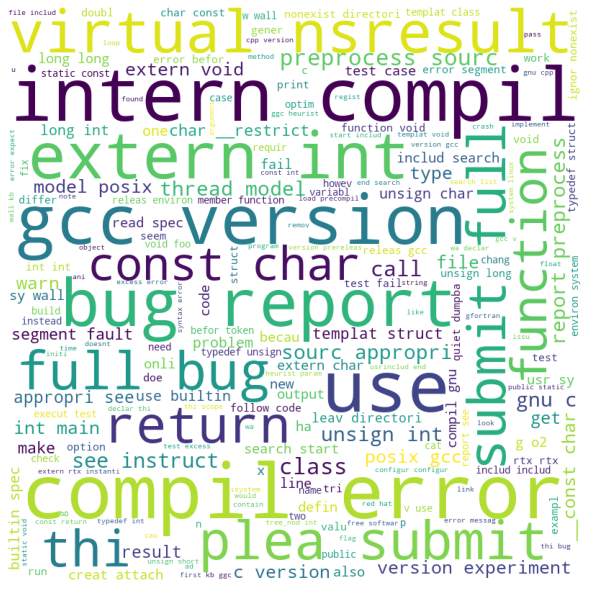

In [512]:
text = " ".join(data['long_description'])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Облако получилось не очень густым, потому что длинные описания содержат длинные куски кода и сырую память.

## Проверим TF-IDF

$$
\text{TF-IDF} (t, d) = \text{TF} (t, d) \times \text{IDF} (t)
$$
где

$\text{TF} (t, d)$ -- *частота слова* (term-frequency), т.е. частота встречаемости слова $t$ в документе $d$;
<br>$\text{IDF} (t) = \frac{1+N}{1+\text{DF} (t)} + 1$ -- *обратная частота документа* (inverse document-frequency), где $\text{DF} (t)$ -- количество документов, содержащих слово $t$.

In [513]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=0.05)
X_short = vectorizer.fit_transform(data['short_description'])
X_long = vectorizer.fit_transform(data['long_description'])
y = data['bug_fix_time_binned']

In [514]:
print(X_short.shape)
print(X_long.shape)

(4973, 11)
(4973, 154)


## Обучение классификаторов

In [515]:
data.head()

,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code,bug_fix_time_binned
0,2011-06-04,34.0,malloc corrupt larg lto1wpa run dure inlin edg...,larg lto1wpa run 20110603 result mallocc3551 m...,203.0,138.0,4,9,2011-10-07,125,2,93
1,2008-06-19,34.0,44 regress build broken cgraph chang,r136888 criself built 4 regress compar earlier...,203.0,841.0,4,5,2008-07-18,29,2,23
4,2000-10-12,5.0,intern compil error layout_decl storlayoutc274,g ihomeleilasourcesinclud o2 wall woverloadedv...,203.0,1179.0,4,5,2001-02-04,115,2,93
5,2001-08-21,32.0,make instal instal includegv3makefil,couldnt work categoryclass problem like thi go...,27.0,1513.0,4,7,2001-10-10,50,2,23
6,2015-07-27,43.0,49 regress wrong code o1 abov arm,creat attach 36076 testca reduc testca base re...,21.0,1415.0,4,14,2016-08-03,373,2,358


In [516]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

models = [
    KNeighborsClassifier(n_neighbors = 5),
    RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_short, y, scoring = 'accuracy', cv = 5, error_score='raise')
  entries.extend((model_name, fold_idx, accuracy)
                 for fold_idx, accuracy in enumerate(accuracies))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [517]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
KNeighborsClassifier,0.227232,0.038002
LinearSVC,0.317314,0.000983
MultinomialNB,0.317917,0.000410
RandomForestClassifier,0.316911,0.001883


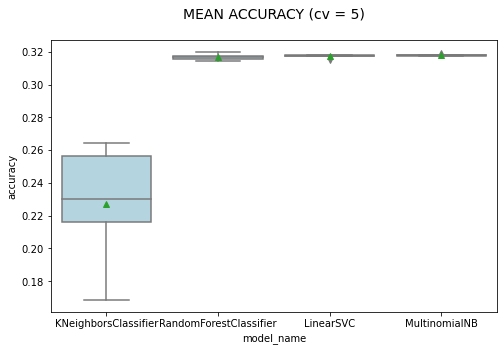

In [518]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

Попробуем тот же подход, но с _long_description_

In [519]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

models = [
    KNeighborsClassifier(n_neighbors = 5),
    RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_long, y, scoring = 'accuracy', cv = 5)
  entries.extend((model_name, fold_idx, accuracy)
                 for fold_idx, accuracy in enumerate(accuracies))
cv_df_long = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [520]:
mean_accuracy_long = cv_df_long.groupby('model_name').accuracy.mean()
std_accuracy_long = cv_df_long.groupby('model_name').accuracy.std()

acc_long = pd.concat([mean_accuracy_long, std_accuracy_long], axis= 1, 
          ignore_index=True)
acc_long.columns = ['Mean Accuracy', 'Standard deviation']
acc_long

,Mean Accuracy,Standard deviation
model_name,,
KNeighborsClassifier,0.256387,0.011998
LinearSVC,0.291373,0.009526
MultinomialNB,0.317716,0.000175
RandomForestClassifier,0.318118,0.001016


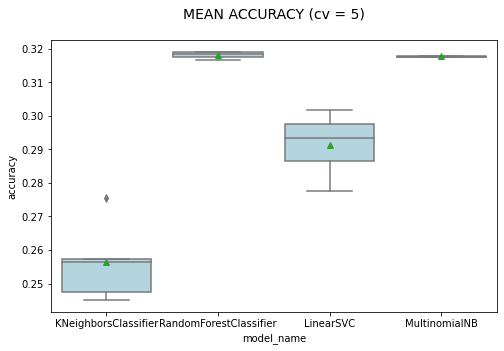

In [521]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df_long, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

В целом результаты удручающие, но ожидаемые, ведь BOW - очень грубый метод.

Попробуем поменять параметры для метода kNN.

In [522]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [523]:
X_knn = data.drop(['bug_fix_time', 'bug_fix_time_binned', 'creation_date', 'resolution_date', 'short_description', 'long_description', 'reporter_name'], axis=1)

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [524]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size = 0.25, random_state = 58)

X_train.shape, X_test.shape

((3729, 5), (1244, 5))

In [525]:
knn_model = KNeighborsClassifier(n_neighbors = 10)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [526]:
%%time
y_train_pred = knn_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * (1 - accuracy_score(y_train, y_train_pred))))

Accuracy score on train data: 34.59%
         Error on train data: 65.41%
CPU times: total: 78.1 ms
Wall time: 73.4 ms


In [527]:
%%time
y_test_pred = knn_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 27.09%
         Error on test  data: 72.91%
CPU times: total: 15.6 ms
Wall time: 23 ms


Видно, что метод kNN плохо подходит к датасету с большим числом текстовых параметров.

In [528]:
%%time

acc_train = []
err_train = []
acc_test = []
err_test = []

k_values = range(5, 51, 5)

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    print('k = {}:'.format(k))
    
    y_train_pred = knn_model.predict(X_train)
    print('    Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
    print('             Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))
    acc_train.append(accuracy_score(y_train, y_train_pred))
    err_train.append(np.mean(y_train != y_train_pred))
    
    y_test_pred = knn_model.predict(X_test)
    print('    Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
    print('             Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))
    acc_test.append(accuracy_score(y_test, y_test_pred))
    err_test.append(np.mean(y_test != y_test_pred))


k = 5:
    Accuracy score on train data: 36.63%
             Error on train data: 63.37%
    Accuracy score on test  data: 26.05%
             Error on test  data: 73.95%
k = 10:
    Accuracy score on train data: 34.59%
             Error on train data: 65.41%
    Accuracy score on test  data: 27.09%
             Error on test  data: 72.91%
k = 15:
    Accuracy score on train data: 33.31%
             Error on train data: 66.69%
    Accuracy score on test  data: 28.46%
             Error on test  data: 71.54%
k = 20:
    Accuracy score on train data: 32.56%
             Error on train data: 67.44%
    Accuracy score on test  data: 30.39%
             Error on test  data: 69.61%
k = 25:
    Accuracy score on train data: 32.31%
             Error on train data: 67.69%
    Accuracy score on test  data: 31.03%
             Error on test  data: 68.97%
k = 30:
    Accuracy score on train data: 32.48%
             Error on train data: 67.52%
    Accuracy score on test  data: 31.27%
          

In [529]:

y_train_pred = pd.Series(knn_model.predict(X_train))
y_test_pred  = pd.Series(knn_model.predict(X_test))

In [530]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)

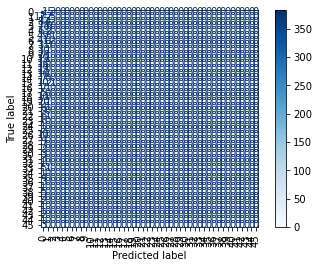

In [531]:
from sklearn.metrics import ConfusionMatrixDisplay

cmd = ConfusionMatrixDisplay(confusion_matrix = cm)
cmd.plot(cmap=plt.cm.Blues, xticks_rotation='vertical');

## Выводы

Получилась низкая точность, потому что способ BoW очень грубый.